This file is to test my model on the TUH-EEG-seizure data

I discretize the data and predit $X_t+dlt$ from X_t with $$X_t+dlt = dlt * (A +I) Xt$$ with only 1 step

In [1]:
RUN_PYTHON_SCRIPT = False
MODEL_NAME = "Lay2_dis_10step_latent_epoch1"
SAVED_MODEL = None
MODEL_CLASS = "my_main_model_dis_base.py"

'my_main_model_dis_base.py'

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MODEL_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import time
# copy file
import shutil

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
import importlib


In [6]:
from models.my_main_model_dis_base import myNet
from models.losses import my_nllloss, ordinal_mse_loss
from models.model_utils import generate_position_encode 
from data_utils.eeg_load import EEG_data, MyDataLoader, digitize_data, rec_data
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder, truncated_mean_upper

In [7]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_device(device)
device

device(type='cuda')

# training

In [13]:
if SAVED_MODEL is None:
    config = edict()
    config.nfeature = 19 # the dim of features at each time point
    config.ndim = 256 # the output of the first FC layer
    config.dropout = 0.5 # the dropout rate
    config.n_layer = 2 # the number of self-attention layers
    config.n_head = 8 # numher of heads for multi-head attention
    config.is_mask = True # Use mask to make the attention causal
    config.is_bias = True # Bias  for layernorm
    config.block_size = 256 # the preset length of seq, 
    config.batch_size = 2 # the batch size
    config.move_step = 10 # k, movestep
    config.fs = 90
    config.target_dim = 19
    config.k = 6 # discretize to 2^k levels
    
    paras_train = edict()
    paras_train.nepoch= 2
    paras_train.loss_out = 10
    paras_train.clip = 1 # 
    paras_train.lr_step = 300
    paras_train.test_loss_out = 50
else:
    saved_model_path = RES_ROOT/SAVED_MODEL
    assert saved_model_path.exists(), "No such model"
    saved_model = load_pkl_folder2dict(saved_model_path)
    
    config = saved_model.config
    paras_train = saved_model.paras_train

In [14]:
def trans_batch(batch):
    """transform the batch to make it easy for training
    """
    batch_dis = digitize_data(batch.cpu().numpy(), config.k)
    batch_rec = rec_data(batch_dis, config.k)
    batch_dis = torch.tensor(batch_dis)
    batch_rec = torch.tensor(batch_rec)
    
    X, Y = batch_rec[:, :-config.move_step], batch_rec[:, config.move_step:]
    Y_dis = batch_dis[:, config.move_step:]
    Y_dis_move = batch_dis[:, (config.move_step-1):-1] # use X_t as prediction of X_t+1
    Y_dis_move = nn.functional.one_hot(Y_dis_move, num_classes=2**config.k).double()
    return X, Y_dis, Y_dis_move


In [15]:
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                      scale_fct=None
                     )
test_data = EEG_data("train_test_health", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False),
                      scale_fct=None
                    )

train_data_loader = MyDataLoader(train_data, batch_size=config.batch_size, shuffle=True)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
print(len(train_data_loader), len(test_data_loader))

259725 12349


In [16]:
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0)
loss_fn = my_nllloss
if SAVED_MODEL is None:
    net = myNet(config)
else:
    net = saved_model.model
    if torch.cuda.is_available():
        net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.1)

number of parameters: 1.59M


In [17]:
def evaluate(net):
    sub_idxs = torch.randint(low=0, high=len(test_data_loader), size=(32, ))
    losses = []
    losses_base = []
    for sub_idx in sub_idxs:
        batch_test = test_data_loader(sub_idx.item())
        X_test, Y_test, Y_test_move = trans_batch(batch_test)
        X_testp = X_test + pos_enc;
        net.eval()
        with torch.no_grad():
            netout = net(X_testp, X_test)
            loss = ordinal_mse_loss(netout, Y_test, num_cls=2**config.k)
            loss_base = ordinal_mse_loss(Y_test_move, Y_test, num_cls=2**config.k)
            #loss = my_nllloss(netout, Y_test, num_cls=2**config.k)
            #loss_base = my_nllloss(Y_test_move, Y_test, num_cls=2**config.k)
        losses.append(loss.item())
        losses_base.append(loss_base.item())
    net.train()
    return np.median(losses), np.median(losses_base)

# training
loss_cur = []
loss_base_cur = []
if SAVED_MODEL is None:
    losses = []
    losses_test = []
else:
    losses = saved_model.losses
    losses_test = saved_model.losses_test

t0 = time.time()
for iep in range(paras_train.nepoch):
    train_data_loader = MyDataLoader(train_data, batch_size=config.batch_size, shuffle=True)
    print(f"The current lr is {scheduler.get_last_lr()}.")
    for ix in range(len(train_data_loader)):
        batch = train_data_loader(ix)
        X, Y, Y_move = trans_batch(batch)
        Xp = X + pos_enc
        # Zero the gradients
        optimizer.zero_grad()
        
        netout = net(Xp, X)
        loss = ordinal_mse_loss(netout, Y, num_cls=2**config.k)
        loss_base = ordinal_mse_loss(Y_move, Y, num_cls=2**config.k)
        #loss = my_nllloss(netout, Y, num_cls=2**config.k)
        #loss_base = my_nllloss(Y_move, Y, num_cls=2**config.k)
        
        # Perform backward pass
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(net.parameters(), paras_train.clip)
        # Perform optimization
        optimizer.step()
        
        loss_cur.append(loss.item())
        loss_base_cur.append(loss_base.item())
        if ix % paras_train.loss_out == (paras_train.loss_out-1):
            losses.append(np.median(loss_cur))
            print(f"At iter {ix+1}/{len(train_data_loader)}, epoch {iep+1}, "
                  f"the losses are {losses[-1]:.3f} (train). "
                  f"the base losses are {np.median(loss_base_cur):.3f} (train). "
                  f"The time used is {delta_time(t0):.3f}s. "
                 )
            loss_cur = []
            loss_base_cur = []
            t0 = time.time()
            
        if ix % paras_train.test_loss_out == (paras_train.test_loss_out-1):
            test_loss = evaluate(net)
            losses_test.append(test_loss[0])
            print(f"At iter {ix+1}/{len(train_data_loader)}, epoch {iep+1}, "
                  f"the losses are {losses_test[-1]:.3f} (test). "
                  f"the base losses are {test_loss[1]:.3f} (test). "
                 )
        
    #if ix % paras_train.lr_step == (paras_train.lr_step-1):
    scheduler.step()
    
    # save the model 
    model_res = edict()
    model_res.config = config
    model_res.loss_fn = loss_fn
    model_res.losses = losses
    model_res.losses_test = losses_test
    model_res.paras_train = paras_train
    
    if SAVED_MODEL is None:
        cur_model_name = f"{MODEL_NAME}_epoch{iep+1}"
    else:
        cur_model_name = f"{MODEL_NAME}_epoch{iep+1}_w_{SAVED_MODEL}"
        
    save_pkl_dict2folder(RES_ROOT/cur_model_name, model_res, is_force=True)
    # save model     
    torch.save(net.state_dict(), RES_ROOT/cur_model_name/"model.pth")
    torch.save(optimizer.state_dict(), RES_ROOT/cur_model_name/"optimizer.pth")
    torch.save(scheduler.state_dict(), RES_ROOT/cur_model_name/"scheduler.pth")
    # copy class file 
    shutil.copy(MODEL_ROOT/MODEL_CLASS, RES_ROOT/cur_model_name/"model_class.py")
    net.cuda()

The current lr is [0.0001].
At iter 10/259725, epoch 1, the losses are 0.245 (train). the base losses are 0.099 (train). The time used is 8.757s. 
At iter 20/259725, epoch 1, the losses are 0.238 (train). the base losses are 0.113 (train). The time used is 7.966s. 
At iter 30/259725, epoch 1, the losses are 0.234 (train). the base losses are 0.098 (train). The time used is 8.087s. 



KeyboardInterrupt



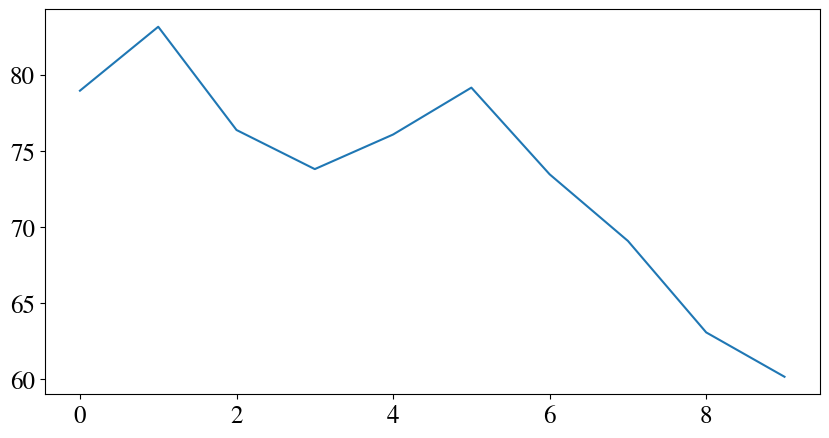

In [20]:
if not RUN_PYTHON_SCRIPT:
    plt.plot(losses)
    #plt.plot(losses_test)
    #plt.yscale("log")